#Submitted by: (Julian Ewaied 215543497), (Sharon Rotgaizer 206941122)

# Deep Q-Network for Cart-Pole.

In this assignment you are required to implement a Deep Q-Network agent, for the Cart-Pole problem.

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent.


__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [ ]:
!pip install stable-baselines3 gym==0.22.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay

In [ ]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


## Cart Pole

In this environment a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

The observation consists of the cart position, cart velocity, pole angle and pole angular velocity.

There are 2 actions corresponding to moving the cart to the left and to the right.

See full description [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/).



In [ ]:
ENV_NAME = "CartPole-v0"

def make_env(seed=None):
    # some envs are wrapped with a time limit wrapper by default
    env = gym.make(ENV_NAME).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


observation dim (4,) number of actions 2


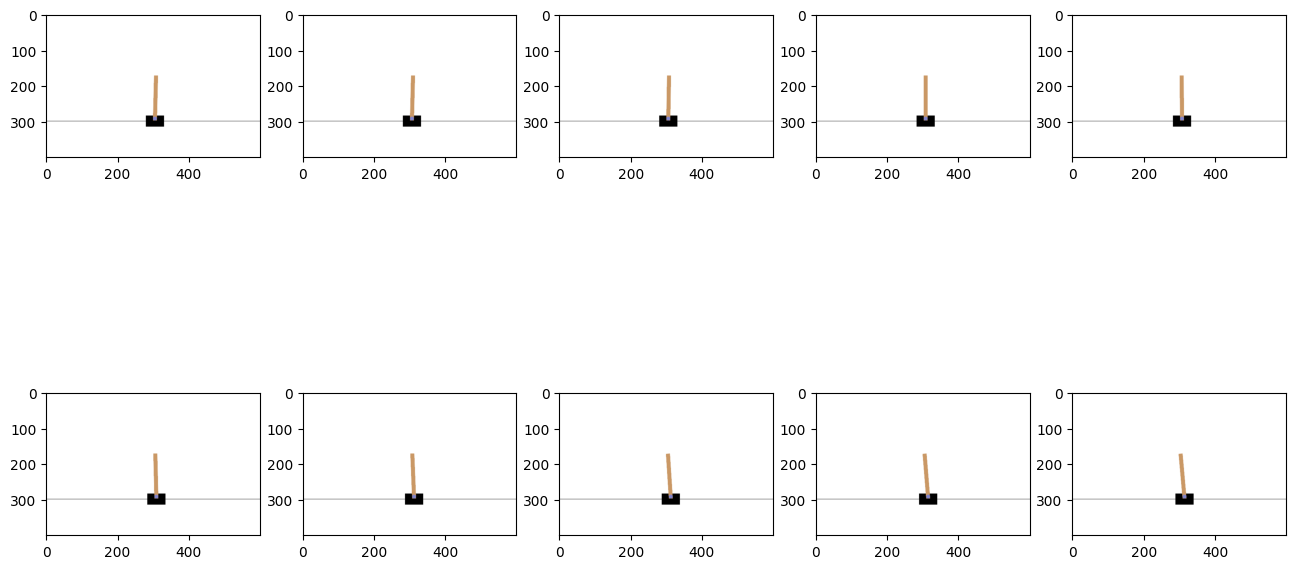

In [ ]:
env = gym.make(ENV_NAME)
obs = env.reset()


n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Assignment

Implement a DQN agent that contains:
1. A neural network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent.

In [ ]:
NUM_PARAMS = env.observation_space.shape[0] # 4
NUM_ACTS = env.action_space.n               # 2
env._max_episode_steps = 1200

In [ ]:
import numpy as np
import random

class EpsilonGreedy(object):

  def __init__(self, epsilon):
    self._epsilon = epsilon

  def get_action(self, qvalues):
    roll = np.random.rand()
    if(roll < self._epsilon):
      action = env.action_space.sample()
    else:
      action =  torch.argmax(qvalues).item()
    return action

class DecayEpsilonGreedy(EpsilonGreedy):

  def __init__(self, epsilon, factor):
    super().__init__(epsilon)
    self._factor = factor

  def get_action(self, qvalues):
    action = super().get_action(qvalues)
    self._epsilon = max(self._epsilon - self._factor, 0.01)

    return action

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

MAX_CAPICITY = 1000
BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNetwork(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(QNetwork, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
    self.fc3 = nn.Linear(hidden_size // 2, output_size)

  def forward(self, x):
    x = F.gelu(self.fc1(x))
    x = F.gelu(self.fc2(x))
    return self.fc3(x)

class Agent(object):

    def __init__(self, hidden_size, discount, epsilon):

        self.action_policy   = DecayEpsilonGreedy(epsilon, 9.99e-2)
        self.replay_buffer   = deque([], maxlen=MAX_CAPICITY)
        self.discount        = discount

        self.target_net   = QNetwork(NUM_PARAMS, hidden_size, NUM_ACTS).to(device)
        self.behavior_net = QNetwork(NUM_PARAMS, hidden_size, NUM_ACTS).to(device)

        self.target_net.load_state_dict(self.behavior_net.state_dict())
        self.target_net.eval()

        self.criterion = nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.behavior_net.parameters(), lr=1e-3)

    def sample_batch(self, batch_size):
        batch  = random.sample(self.replay_buffer, batch_size)
        state  = torch.stack ([sample[0] for sample in batch])
        action = torch.tensor([sample[1] for sample in batch], device=device)
        reward = torch.tensor([sample[2] for sample in batch], device=device)
        next_s = torch.stack ([sample[3] for sample in batch])
        done = torch.stack ([sample[4] for sample in batch])
        return state,action,reward,next_s,done

    def optimize(self):

        batch_size                            = min(len(self.replay_buffer), BATCH_SIZE)
        state, action, reward, next_s, done   = self.sample_batch(batch_size)

        behavior                             = self.behavior_net(state)

        Q_behavior                           = behavior[torch.arange(behavior.size(0)),action]

        Q_values                             = self.target_net(next_s)
        bootstrap, _                         = torch.max(Q_values, dim=1)

        targets = torch.where(done, reward, reward + self.discount * bootstrap)

        self.optimizer.zero_grad()
        loss = self.criterion(targets, Q_behavior)
        loss.backward()

        self.optimizer.step()

        return loss.item()

    def update(self, state, action, reward, next_state, done):

        if reward is not None:
            self.replay_buffer.append([state, action, reward, next_state, done])

        return self.optimize()

    def step(self, state):
        qvalues = self.behavior_net(state)
        return self.action_policy.get_action(qvalues)


## Training

Game: 0, Time: 10.0, Loss: 0.4249869495630264
Game: 50, Time: 10.0, Loss: 0.2050166768811323
Game: 100, Time: 16.0, Loss: 0.043999344401527196
Game: 150, Time: 150.0, Loss: 0.06230108752225836
Game: 200, Time: 161.0, Loss: 0.10027401035044903
Game: 250, Time: 182.0, Loss: 0.052827397809628716
Game: 300, Time: 210.0, Loss: 0.019083656872057222
Game: 350, Time: 359.0, Loss: 0.001457653835570358
Game: 400, Time: 1200.0, Loss: 0.02091058919753171


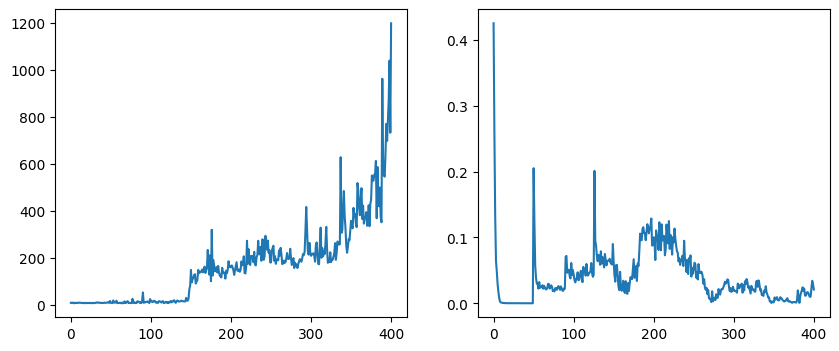

In [ ]:
import matplotlib.pyplot as plt

agent = Agent(hidden_size=64, discount=0.99, epsilon=0.5)

rewards = []
losses = []

n_games = 401
step = 0
max_iter=int(1e4)

for game_num in range(n_games):

    s = torch.tensor(env.reset(), device=device)
    done = False

    reward_acc = 0
    loss_acc = 0

    curr_iter = 0

    while not done:
        action = agent.step(s)
        step += 1
        curr_iter += 1

        next_s, r, done, _ = env.step(action)

        r = torch.tensor(r, device=device)
        done = torch.tensor(done, device=device)
        next_s = torch.tensor(next_s, device=device)

        loss_acc += agent.update(s, action, r, next_s, done)

        s = next_s
        reward_acc += r.cpu()

        if step % 500 == 0:
            agent.target_net.load_state_dict(agent.behavior_net.state_dict())

        if done:
            break

    rewards.append(reward_acc)
    losses.append(loss_acc/curr_iter)

    if game_num % 50 == 0:
        print(f"Game: {game_num}, Time: {rewards[-1]}, Loss: {losses[-1]}")

agent.target_net.load_state_dict(agent.behavior_net.state_dict())

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(rewards, label='rewards')

plt.subplot(1, 2, 2)
plt.plot(losses, label='loss')
plt.show()

In [ ]:
def evaluate_DQN(env, agent, n_games=1, t_max=10000):
    rewards = []

    for _ in range(n_games):
        s = torch.tensor(env.reset(), device=device)
        reward = 0
        done = False
        while not done:
            action = agent.step(s)
            previous_state = s
            s, r, done, _ = env.step(action)
            s = torch.tensor(s, device=device)
            reward += r
            if done:
              break
        rewards.append(reward)
    return np.mean(rewards)

agent.target_net.eval()
agent.behavior_net.eval()
mean_reward = evaluate_DQN(env, agent, n_games=5)

In [ ]:
# run sessions

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    #env_monitor.reset()
    sessions = [evaluate_DQN(env_monitor, agent, n_games=3) for _ in range(10)]

In [ ]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))